<a href="https://colab.research.google.com/github/conorlime/CS6271/blob/main/GE%20Applied%20to%20Parity%20Problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#**Artificial Intelligence - MSc**
##CS6271 - Evolutionary Agorithms and Humanoid Robotics
###GRAPE code running parity problems with 3, 4 or 5 bits


Leader: Conor Ryan

Developer: Allan de Lima

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Clone this repository in which we have all functions and classes created or adapted to this work.

In [2]:
import os.path

PATH = '/content/drive/MyDrive/grape/'
if os.path.exists(PATH):
    print('grape directory already exists')
else:
    %cd /content/drive/MyDrive/
    !git clone https://github.com/UL-BDS/grape.git
    print('Cloning grape in your Drive')

%cd /content/drive/MyDrive/grape/

grape directory already exists
/content/drive/MyDrive/grape



Import our algorithms, adapted from deap.algorithms.

Import DEAP.

Import functions used by our grammars.



In [3]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [4]:
!pip install deap

import grape
import algorithms
from functions import not_, and_, or_, nand_, nor_

from os import path
import pandas as pd
import numpy as np
from deap import creator, base, tools

import random
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.2 MB/s eta 0:00:00


Set our Grammatical Evolution parameters.

In [15]:
POPULATION_SIZE = 500
MAX_GENERATIONS = 50
P_CROSSOVER = 0.8
P_MUTATION = 0.01
ELITE_SIZE = 1 #round(0.01*POPULATION_SIZE) #it should be smaller or equal to HALLOFFAME_SIZE
HALLOFFAME_SIZE = 1 #round(0.01*POPULATION_SIZE) #it should be at least 1

CODON_CONSUMPTION = 'lazy'
GENOME_REPRESENTATION = 'list'
MAX_GENOME_LENGTH = None

MAX_INIT_TREE_DEPTH = 13
MIN_INIT_TREE_DEPTH = 3
MAX_TREE_DEPTH = 35
MAX_WRAPS = 0
CODON_SIZE = 255

REPORT_ITEMS = ['gen', 'invalid', 'avg', 'std', 'min', 'max',
                'best_ind_length', 'avg_length',
                'best_ind_nodes', 'avg_nodes',
                'avg_depth',
                'avg_used_codons', 'best_ind_used_codons',
                'selection_time', 'generation_time']


Set a random seed.

In [6]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

Set a problem to solve. We can choose 'parity3', 'parity4' or 'parity5'.

The parameters in the previous cell are recommended to solve the problem with 3 bits.

In [7]:
problem = 'parity3'

Read datasets and grammars according to the problem picked in the previous cell.

Notice we read the data in from a file rather than simply generate it. While not strictly necessary, it is a nice piece of functionality that we'll use in later notebooks.

In [8]:
if problem == 'parity3':
    X_train = np.zeros([3,8], dtype=bool)
    Y_train = np.zeros([8,], dtype=bool)

    data = pd.read_table(r"datasets/parity3.csv")
    for i in range(3):
        for j in range(8):
            X_train[i,j] = data['d'+ str(i)].iloc[j]
    for i in range(8):
        Y_train[i] = data['output'].iloc[i]

    GRAMMAR_FILE = 'parity3.bnf'

elif problem == 'parity4':
    X_train = np.zeros([4,16], dtype=bool)
    Y_train = np.zeros([16,], dtype=bool)

    data = pd.read_table(r"datasets/parity4.csv")
    for i in range(4):
        for j in range(16):
            X_train[i,j] = data['d'+ str(i)].iloc[j]
    for i in range(16):
        Y_train[i] = data['output'].iloc[i]

    GRAMMAR_FILE = 'parity4.bnf'

elif problem == 'parity5':
    X_train = np.zeros([5,32], dtype=bool)
    Y_train = np.zeros([32,], dtype=bool)

    data = pd.read_table(r"datasets/parity5.csv")
    for i in range(5):
        for j in range(32):
            X_train[i,j] = data['d'+ str(i)].iloc[j]
    for i in range(32):
        Y_train[i] = data['output'].iloc[i]

    GRAMMAR_FILE = 'parity5.bnf'

Print data.

In [9]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(data)

,d0,d1,d2,output
0,0,0,0,1
1,0,0,1,0
2,0,1,0,0
3,0,1,1,1
4,1,0,0,0
5,1,0,1,1
6,1,1,0,1
7,1,1,1,0


Print grammar.

In [10]:
f = open("grammars/" + GRAMMAR_FILE, "r")
print(f.read())
f.close()

<e>  ::=  <op> | <x>
<op> ::=  and_(<e>,<e>)|
          or_(<e>,<e>)|
          nand_(<e>,<e>)|
          nor_(<e>,<e>)
<x> ::=   x[0]|x[1]|x[2]



Set up the grammar addressed by GRAMMAR_FILE in the class Grammar.

In [11]:
BNF_GRAMMAR = grape.Grammar(path.join("grammars", GRAMMAR_FILE))

Define as fitness function the number of outputs wrongly predicted.

In [12]:
def fitness_eval(individual, points):
    x = points[0]
    Y = points[1]

    if individual.invalid == True:
        return np.NaN,

    # Evaluate the expression
    try:
        pred = eval(individual.phenotype)
    except (FloatingPointError, ZeroDivisionError, OverflowError,
            MemoryError):
        # FP err can happen through eg overflow (lots of pow/exp calls)
        # ZeroDiv can happen when using unprotected operators
        return np.NaN,
    assert np.isrealobj(pred)

    # The expected outputs are in Y
    n_samples = len(Y)
    compare = np.equal(Y,pred) # Compare the outputs with the expected values
    n_correct_outputs = np.sum(compare)

    fitness = n_samples - n_correct_outputs

    return fitness,

Create the deap toolbox.

Use negative weights in the `base.Fitness` since we are trying to minimise the fitness.

`grape.Individual` is a class with the following attributes: `phenotype`, `nodes`, `depth`, `used_codons`, `invalid` (True or False), `n_wraps` and `self.structure`.

`grape.sensible_initialisation` initialises a whole population of GE individuals using Sensible Initialisation.

`tools.selTournament` usef Tournament to select parents.

`grape.crossover_onepoint` selects crossover points within the used portion of the genome.

Similarly, `grape.mutation_int_flip_per_codon` performs only over the effective length.



In [13]:
toolbox = base.Toolbox()

# define a single objective, minimising fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create('Individual', grape.Individual, fitness=creator.FitnessMin)

toolbox.register("populationCreator", grape.sensible_initialisation, creator.Individual)
#toolbox.register("populationCreator", grape.random_initialisation, creator.Individual)

toolbox.register("evaluate", fitness_eval)

# Tournament selection:
toolbox.register("select", tools.selTournament, tournsize=6)

# Single-point crossover:
toolbox.register("mate", grape.crossover_onepoint)

# Flip-int mutation:
toolbox.register("mutate", grape.mutation_int_flip_per_codon)

Set the main function and run it.

Set the statistics object regarding the fitness score, but there are other statistics defined internally.

Perform Grammatical Evolution using `algorithms.ge_eaSimpleWithElitism`, a simple evolutionary algorithm. The differences to the `algorithms.ge_eaSimpleWithElitism` used by deap are:

*   We use elitism (if you do not want to use, just set ELITISM_SIZE = 0);
*   After crossover and mutation, we check the offspring to assure that the max depth is not violated;
*   We measure many other things to report, such as the generation and the selection times, the number of invalid individuals etc.

In [16]:
# create initial population (generation 0):
population = toolbox.populationCreator(pop_size=POPULATION_SIZE,
                                      bnf_grammar=BNF_GRAMMAR,
                                      min_init_depth=MIN_INIT_TREE_DEPTH,
                                      max_init_depth=MAX_INIT_TREE_DEPTH,
                                      codon_size=CODON_SIZE,
                                      codon_consumption=CODON_CONSUMPTION,
                                      genome_representation=GENOME_REPRESENTATION
                                      )

# define the hall-of-fame object:
hof = tools.HallOfFame(HALLOFFAME_SIZE)

# prepare the statistics object:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

# perform the Grammatical Evolution flow:
population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                              bnf_grammar=BNF_GRAMMAR,
                                              codon_size=CODON_SIZE,
                                              max_tree_depth=MAX_TREE_DEPTH,
                                              max_genome_length=MAX_GENOME_LENGTH,
                                              points_train=[X_train, Y_train],
                                              codon_consumption=CODON_CONSUMPTION,
                                              report_items=REPORT_ITEMS,
                                              genome_representation=GENOME_REPRESENTATION,
                                              stats=stats, halloffame=hof, verbose=False)

gen = 0 , Best fitness = (2.0,)
gen = 1 , Best fitness = (2.0,) , Number of invalids = 121
gen = 2 , Best fitness = (2.0,) , Number of invalids = 100
gen = 3 , Best fitness = (2.0,) , Number of invalids = 89
gen = 4 , Best fitness = (1.0,) , Number of invalids = 98
gen = 5 , Best fitness = (1.0,) , Number of invalids = 98
gen = 6 , Best fitness = (1.0,) , Number of invalids = 87
gen = 7 , Best fitness = (1.0,) , Number of invalids = 70
gen = 8 , Best fitness = (1.0,) , Number of invalids = 65
gen = 9 , Best fitness = (1.0,) , Number of invalids = 73
gen = 10 , Best fitness = (1.0,) , Number of invalids = 77
gen = 11 , Best fitness = (1.0,) , Number of invalids = 68
gen = 12 , Best fitness = (1.0,) , Number of invalids = 72
gen = 13 , Best fitness = (1.0,) , Number of invalids = 76
gen = 14 , Best fitness = (1.0,) , Number of invalids = 72
gen = 15 , Best fitness = (1.0,) , Number of invalids = 79
gen = 16 , Best fitness = (1.0,) , Number of invalids = 77
gen = 17 , Best fitness = (1.0,

Extract statistics and build a nice looking table.

In [17]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")

best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")

selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")
avg_used_codons = logbook.select("avg_used_codons")
best_ind_used_codons = logbook.select("best_ind_used_codons")

best_ind_nodes = logbook.select("best_ind_nodes")
avg_nodes = logbook.select("avg_nodes")

avg_depth = logbook.select("avg_depth")

header = REPORT_ITEMS

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values,
                                min_fitness_values, max_fitness_values,
                                best_ind_length, avg_length,
                                best_ind_nodes, avg_nodes,
                                avg_depth,
                                avg_used_codons, best_ind_used_codons,
                                selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,best_ind_length,avg_length,best_ind_nodes,avg_nodes,avg_depth,avg_used_codons,best_ind_used_codons,selection_time,generation_time
0,0,0,3.996000,0.525342,2.0,6.0,189,102.060000,32,17.510000,8.936000,68.040000,126,0.000000,0.128888
1,1,121,3.815303,0.560511,2.0,7.0,189,137.707124,32,15.736148,11.026385,60.944591,126,0.008678,0.552914
2,2,100,3.672500,0.700174,2.0,6.0,189,165.815000,32,18.630000,13.475000,72.520000,126,0.006771,0.617462
3,3,89,3.525547,0.774411,2.0,6.0,189,184.676399,32,21.635036,15.486618,84.540146,126,0.006149,0.728470
4,4,98,3.465174,0.866761,1.0,6.0,244,194.925373,24,21.308458,15.726368,83.233831,94,0.006477,0.733717
5,5,98,3.328358,0.949806,1.0,6.0,244,208.278607,24,23.333333,16.343284,91.333333,94,0.008675,0.779611
6,6,87,3.184019,0.989062,1.0,6.0,244,230.452785,24,24.968523,16.564165,97.874092,94,0.006487,0.793182
7,7,70,3.069767,0.999892,1.0,5.0,244,250.832558,24,24.769767,16.734884,97.079070,94,0.003283,0.458175
8,8,65,3.105747,1.127642,1.0,7.0,244,288.450575,24,25.595402,17.197701,100.381609,94,0.003237,0.466456
9,9,73,2.836066,1.084838,1.0,6.0,244,308.789227,24,27.358314,17.665105,107.433255,94,0.003208,0.503944


Show the best individual as an expression.

In [18]:
import textwrap
best = hof.items[0].phenotype
print("Best individual: \n","\n".join(textwrap.wrap(best,80)))
print("\nTraining Fitness: ", hof.items[0].fitness.values[0])

print("Depth: ", hof.items[0].depth)
print("Length of the genome: ", len(hof.items[0].genome))
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')

Best individual: 
 nor_(and_(nand_(and_(nand_(x[0],x[1]),nor_(x[1],x[2])),nor_(and_(x[0],x[0]),or_(
x[2],x[2]))),or_(or_(nand_(x[2],x[2]),nor_(x[2],x[0])),and_(nand_(x[1],x[1]),nan
d_(x[0],x[0])))),nor_(nand_(and_(x[1],x[1]),and_(x[0],x[1])),nor_(and_(x[1],x[1]
),or_(x[2],x[0]))))

Training Fitness:  1.0
Depth:  13
Length of the genome:  244
Used portion of the genome: 0.39


Plot graphs regarding the best fitness and the average fitness.

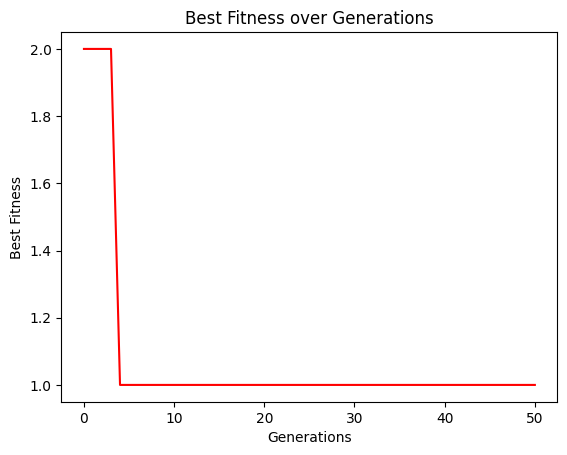

In [19]:
plt.plot(min_fitness_values, color='red')
plt.xlabel('Generations')
plt.ylabel('Best Fitness')
plt.title('Best Fitness over Generations')
plt.show()


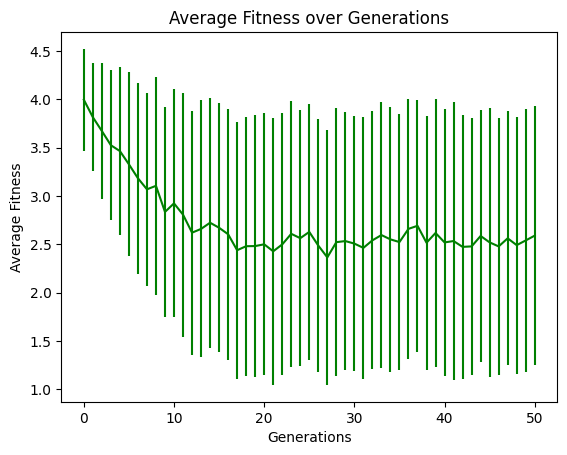

In [20]:
gen = np.arange(0, 50+1)

plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values,label="Best", color="Green")
plt.show()

Plot graphs regarding the length of the genome: the average of the population and that one of the best individual.


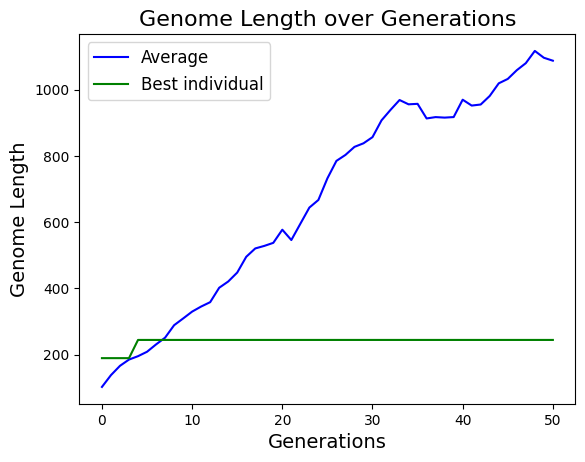

In [21]:
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()